# Step-by-step example of JDFLOW.
## Kirill Zakharov
2024

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline

import torch
from torch import optim
from torch.autograd import Variable, grad
from torch.autograd.functional import jacobian
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.multivariate_normal import MultivariateNormal

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.special import rel_entr, kl_div, factorial
from scipy.spatial.distance import jensenshannon
from scipy.stats import kstest, ks_2samp, wasserstein_distance
from scipy.optimize import minimize
import scipy.stats as sts
from tqdm import tqdm
import itertools


from JDFLOW.intensity_optimization import *
from JDFLOW.signature_computation import *
from JDFLOW.stochastic_processes import *
from JDFLOW.nsde_functions import *
from JDFLOW.nsde_solvers import *
from JDFLOW.jdflow import *
from JDFLOW.evaluate.metrics import *
from JDFLOW.evaluate.graphics import *
from JDFLOW.FourierFlows import FourierFlow
from JDFLOW.FSDE import train_fsde

from Model import inverse_preprocessing

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

In [2]:
import matplotlib as mpl
#set params for the article
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 13
mpl.rcParams['axes.labelsize'] = 14

#set params for the notebook
# mpl.rcParams['xtick.labelsize'] = 12
# mpl.rcParams['ytick.labelsize'] = 12
# mpl.rcParams['legend.fontsize'] = 10
# mpl.rcParams['axes.labelsize'] = 14

## Data Preparation

In [8]:
def choose_data(name='DCL', n=300, M=10, **kwargs):
    dt = 1/n
    if name == 'DCL':
        data = dclProcess(n, M, theta=kwargs['theta'], delta=kwargs['delta'], T=kwargs['T']).T
    
    elif name == 'Merton':
        data = np.array([merton_process(s0=kwargs['s0'], xiP=kwargs['xiP'], muj=kwargs['muj'], sigmaj=kwargs['sigmaj'], r=kwargs['r'],\
                        sigma=kwargs['sigmad'], n=n, T=kwargs['T']) for i in range(M)])
    
    elif name == 'GBM':
        data = np.array([geometric_BM(s0=kwargs['s0'], mu=kwargs['mu'], sigma=kwargs['sigma'], n=n, T=kwargs['T']) for i in range(M)])
        
    elif name == 'Stock':
        data = pd.read_csv(kwargs['filename'])
        data = data[['Open', 'High', 'Low', 'Close']].values.T
        n = len(data[0])
        dt = 1/n
        
    return data, dt, n

In [18]:
data, dt, n = choose_data('Merton', s0=2, xiP=7, muj=0, sigmaj=0.2, r=0.04, sigmad=1, T=1)
# data, dt, n = choose_data('DCL', theta=1, delta=2, T=1)
# data, dt, n = choose_data('GBM', s0=1, mu=0.2, sigma=0.9, T=1)
# data, dt, n = choose_data('Stock', filename='Data/gen.us.txt')

In [4]:
# np.save('Data/Merton_jump_diffusion.npy', data)

In [3]:
# data = np.load('Data/Merton_jump_diffusion.npy')
# n = len(data[0]) - 1
# dt = 1/n

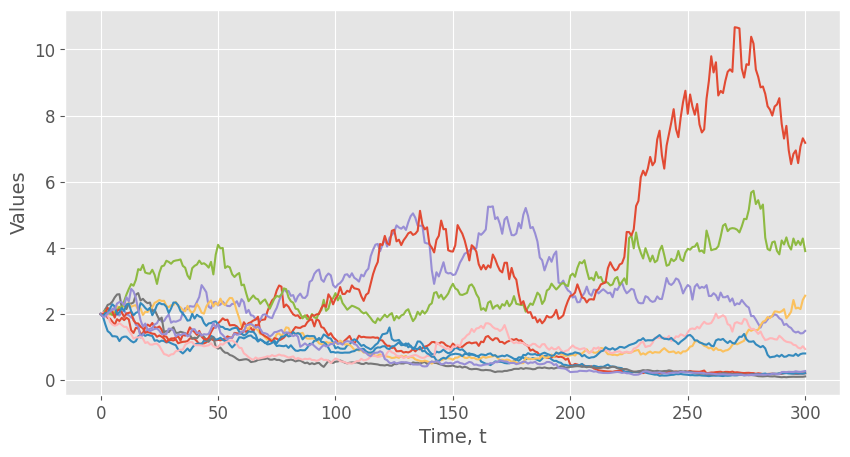

In [20]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(data.T)

plt.xlabel('Time, t')
plt.ylabel('Values')
plt.show()

Save initial data

In [5]:
data_save = copy.deepcopy(torch.FloatTensor(data))

Preprocess the data

In [6]:
scaler = MinMaxScaler((0, 1))
data = scaler.fit_transform(data.T).T

In [7]:
data_tensor = torch.FloatTensor(data)
data0 = data_tensor[0]

## Identify jump intensity

Choose the $\lambda_j$ to identify the initial jump intensity in the whole data set.

In [8]:
lambda_j = 0.2
idx_jumps = list(map(lambda x: find_jumps(x, lambda_j), data_save))

Black points show the jump positions in the inital data.

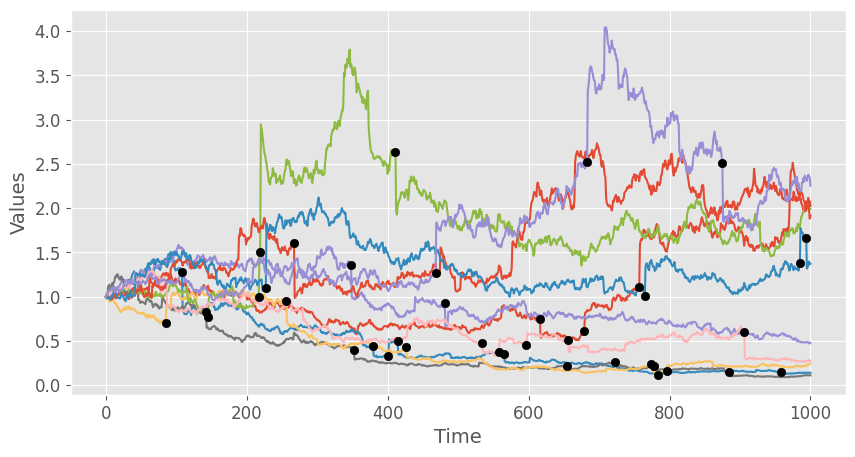

In [9]:
plot_jumps(data_save, idx_jumps)

Initial intensity

In [10]:
init_intensity = estimate_init_intensity_array(data_save, idx_jumps)/dt
init_intensity

array([2.997003  , 5.99400599, 1.998002  , 5.99400599, 5.99400599,
       3.996004  , 4.995005  , 0.999001  , 3.996004  , 2.997003  ])

Initital parameters

In [11]:
jump_part, diff_part = separate_dynamics(data_save, idx_jumps)
init_params = estimate_init_params(data_save, jump_part, diff_part, dt)

Maximize likelihood

In [13]:
opt_params = optimize_params(data_save, init_params, init_intensity, dt)

In [14]:
xiP0 = opt_params[-1]
xiP0

3.9960039960039957

## Signature Examples

In [18]:
signature_traj = compute_path_signature_torch(data_save, level_threshold=3)
signature = signature_set(signature_traj)[1:]

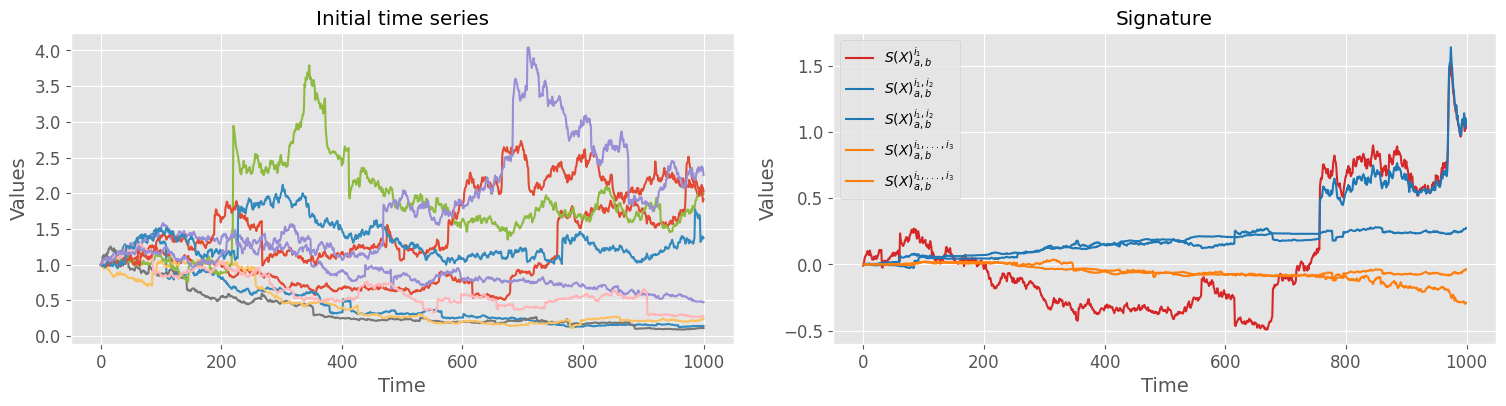

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4), dpi=100)

axs[0].plot(data_save.T)
axs[0].set_title('Initial time series')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Values')

axs[1].plot(signature_traj[1][0], color='tab:red', label='$S(X)_{a,b}^{i_1}$')
axs[1].plot(signature_traj[2][0], color='tab:blue', label='$S(X)_{a,b}^{i_1,i_2}$')
axs[1].plot(signature_traj[2][4], color='tab:blue', label='$S(X)_{a,b}^{i_1,i_2}$')
axs[1].plot(signature_traj[3][2], color='tab:orange', label='$S(X)_{a,b}^{i_1,...,i_3}$')
axs[1].plot(signature_traj[3][4], color='tab:orange', label='$S(X)_{a,b}^{i_1,...,i_3}$')
# plt.plot(signature_traj[9][0], color='tab:blue', label='$S(X)_{a,b}^{i_1,\dots,i_9}$')
axs[1].legend(fontsize=10, loc=2)
axs[1].set_title('Signature')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Values')

plt.tight_layout(pad=0.5)
plt.subplots_adjust(wspace=0.15)
# plt.savefig('Signature_ex4.pdf', dpi=300)
plt.show()

## Train model

In [20]:
class DiffMap(nn.Module):
    def __init__(self, time_steps, h_dim, M, dt, permute):
        super(DiffMap, self).__init__()
    
        self.h_dim = h_dim
        self.laten_dim = M
        self.time_steps = time_steps
        self.dt = dt

        hidden = 2**7
        self.d = h_dim // 2
        self.permute = permute
        
        self.in_size = self.d
        self.out_size = self.h_dim - self.d

        if self.permute:
            self.in_size, self.out_size = self.out_size, self.in_size

        
        self.fc_mu = nn.Sequential(
            # nn.LSTM(self.in_size, self.in_size, num_layers=1, batch_first=True),
            # extract_tensor(),
            # nn.Sigmoid(),
            nn.Linear(self.in_size, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, self.out_size)
        )
        self.fc_sig = nn.Sequential(
            nn.LSTM(self.in_size, self.in_size, num_layers=1, batch_first=True),
            extract_tensor(),
            nn.Sigmoid(),
            nn.Linear(self.in_size, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, self.out_size)
        )
        self.nu = nn.Sequential(
            nn.Linear(M, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, M)
        )
   
        self.p = nn.Sequential(
            nn.Linear(self.time_steps, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, self.in_size)
        )
        self.tanh = nn.Tanh()
        
        self.f = nn.Sequential(nn.Linear(self.in_size, hidden),
                               nn.Sigmoid(),
                               nn.Linear(hidden, self.out_size))
        
        self.base_dist = MultivariateNormal(torch.zeros(h_dim), torch.eye(h_dim))

    def forward(self, x, vt):
        x1, x2 = x[:, :self.d], x[:, self.d:]
    
        if self.permute:
            x2, x1 = x1, x2
        
        p_hat = self.tanh(self.p(vt.T))
        z1 = x1 + p_hat
        sig = self.fc_sig(z1)
        
        z2 = self.fc_mu(z1) * self.f(self.nu(z1.T).T)  + x2 * torch.exp(sig)
        # * self.f(self.nu(z1.T).T)
       
        if self.permute:
            z2, z1 = z1, z2 
 
        z = torch.cat([z1, z2], axis=1)
        
        log_pz = self.base_dist.log_prob(z)
        log_jacob = sig.sum(-1)

        return z, log_pz, log_jacob
    
        

    def inverse(self, z, vt):
        z1, z2 = z[:, :self.d], z[:, self.d:]
        
        if self.permute:
            z2, z1 = z1, z2
            
        x2 = (z2 - self.fc_mu(z1) * self.f(self.nu(z1.T).T)) * torch.exp(-self.fc_sig(z1))
        # * self.f(self.nu(vt).T)
        # * self.f(self.nu(z1.T).T)
        # * self.f(vt.T)

      
        p_hat = self.tanh(self.p(vt.T))
        x1 = z1 - p_hat
      
        if self.permute:
            x2, x1 = x1, x2
        
        x = torch.cat([x1, x2], axis=1)

        return x



class JDFlow(nn.Module):
    def __init__(self, n_flows, h_dim, M, time_steps, dt, sig_dim, xiP0):
        super(JDFlow, self).__init__()
        
        self.h_dim = h_dim
        self.permute = [True if i % 2 else False for i in range(n_flows)]

        self.bijections = nn.ModuleList(
            [DiffMap(time_steps, h_dim, M, dt, self.permute[i]) for i in range(n_flows)]
        )
        
        self.xiP = xiP0
        
        self.time_steps = time_steps
        self.dt = dt
        self.M = M
        self.psi = Operator_F(self.time_steps, self.h_dim)
        self.zeta = Operator_F(self.h_dim, self.h_dim)
        
        self.drift = Drift(self.M)
        self.diffusion = Diffusion(self.M, 1)
        self.jump = Jump(self.M)
        self.phi = Phi(self.M, M, M)
        

    def forward(self, x):
        log_jacobs = []
        
        wt = torch.randn((1, self.M))
        v0 = self.phi(wt, x[:, 0].view(1, x.size(0)) + torch.randn((1, x.size(0))) )
        self.vt = sdeint_jump(self.drift, self.diffusion, self.jump, self.dt, v0, self.time_steps, self.M, self.xiP)
        
        self.non_linearity = torch.exp(-self.psi(self.vt.T))
        x = self.non_linearity * x + self.zeta(self.non_linearity)
        

        for bijection in self.bijections:
            x, log_pz, lj = bijection(x, self.vt.detach())

            log_jacobs.append(lj)

        return x, log_pz, sum(log_jacobs), self.vt

    def inverse(self, z):
        
        wt = torch.randn((1, self.M))
        v0 = self.phi(wt, z[:, 0].view(1, z.size(0)) + torch.randn((1, z.size(0))) )
        self.vt = sdeint_jump(self.drift, self.diffusion, self.jump, self.dt, v0, self.time_steps, self.M, self.xiP) 

        for bijection in reversed(self.bijections):
            z = bijection.inverse(z, self.vt)
            
        self.non_linearity = torch.exp(-self.psi(self.vt.T))
        z = (z - self.zeta(self.non_linearity)) / self.non_linearity

        return z
    
    def fit(self, X, epochs=1000, learning_rate=1e-3, batch_size=1):
        optim = torch.optim.Adam(self.bijections.parameters(), lr=learning_rate)
        optim_psi = torch.optim.Adam(self.psi.parameters(), lr=learning_rate)
        optim_zeta = torch.optim.Adam(self.zeta.parameters(), lr=learning_rate)
        optim_phi = torch.optim.Adam(self.phi.parameters(), lr=learning_rate)
        
        optim_drift = torch.optim.Adam(self.drift.parameters(), lr=3e-4)
        optim_diff = torch.optim.Adam(self.diffusion.parameters(), lr=3e-4)
        optim_jump = torch.optim.Adam(self.jump.parameters(), lr=3e-4)
        
        
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[400, 900], gamma=0.3)
       
        losses = []
        epochs = tqdm(range(epochs))
        # mse = nn.MSELoss()
        # loader = DataLoader(data_tensor, batch_size=batch_size, shuffle=True)

        for _ in epochs:
            # for x in loader:
                _, log_pz, log_jacob, vt = self.forward(X)
                
                # p_Z = MultivariateNormal(torch.zeros(self.time_steps-1), torch.eye(self.time_steps-1))
                # z = p_Z.rsample(sample_shape=(self.time_steps,))
                # synth_x = self.inverse(z)
                
                # signature = (stack_signatures(compute_path_signature_torch(synth_x, level_threshold=2)[1:]))
                # signature_true = (stack_signatures(compute_path_signature_torch(X, level_threshold=2)[1:]))
                
                loss_likelihood = (-log_pz - log_jacob).mean() 
            
                # loss_sig = mse(signature, signature_true)
                # loss_init_values = torch.mean((X[:, 0] - synth_x[:, 0])**2)
                loss_sig = loss_likelihood
                loss_init_values = loss_likelihood
                
                total_norm = 0.0
                for p in self.parameters():
                    param_norm = p.norm(2)
                    total_norm += param_norm.item() ** 2
                    total_norm = total_norm ** (1. / 2)
            
                
                loss = loss_likelihood + total_norm
                # + 0.01 * loss_sig + loss_init_values + total_norm
                

                optim.zero_grad()
                optim_drift.zero_grad()
                optim_diff.zero_grad()
                optim_jump.zero_grad()
                optim_psi.zero_grad()
                optim_zeta.zero_grad()
                optim_phi.zero_grad()
                
                loss.backward()
                
                optim.step()
                optim_drift.step()
                optim_diff.step()
                optim_jump.step()
                optim_psi.step()
                optim_zeta.step()
                optim_phi.step()
                
                scheduler.step()

                epochs.set_description(f'Loss: {round(loss.item(), 4)}')
                losses.append([loss_likelihood.item(), loss_init_values.item(), loss_sig.item()])
            
        return np.array(losses)
            
    
    def sample(self, n_samples):
        samples_array = []
        p_Z = MultivariateNormal(torch.zeros(self.h_dim), torch.eye(self.h_dim))
            
        if n_samples % self.M == 0:
            for i in range(n_samples // self.M):
                z = p_Z.rsample(sample_shape=(self.M,))

                X_sample = self.inverse(z).detach().numpy()
                samples_array.append(X_sample)
                
            samples_array = np.vstack(samples_array)
                
        else:
            for i in range(n_samples // self.M + 1):
                z = p_Z.rsample(sample_shape=(self.M,))

                X_sample = self.inverse(z).detach().numpy()
                samples_array.append(X_sample)
              
            samples_array = np.vstack(samples_array)[:n_samples]

        return samples_array

In [21]:
# data_tensor = data_tensor.view(1, -1) #if use only one series

In [22]:
h_dim = len(data_tensor[0])
M = data_tensor.size(0)
BS = M
time_steps = 100
dt = torch.FloatTensor([1/time_steps])
sig_dim = n + n**2 

In [23]:
n_flows = 10

nsde_flow = JDFlow(n_flows, h_dim, BS, time_steps, dt, sig_dim, xiP0)

losses = nsde_flow.fit(data_tensor, epochs=1000, batch_size=BS)

Loss: -4916.1362: 100%|██████████| 1000/1000 [03:38<00:00,  4.59it/s]


In [24]:
nsde_flow.eval()

JDFlow(
  (bijections): ModuleList(
    (0): DiffMap(
      (fc_mu): Sequential(
        (0): Linear(in_features=500, out_features=128, bias=True)
        (1): Sigmoid()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): Sigmoid()
        (4): Linear(in_features=128, out_features=501, bias=True)
      )
      (fc_sig): Sequential(
        (0): LSTM(500, 500, batch_first=True)
        (1): extract_tensor()
        (2): Sigmoid()
        (3): Linear(in_features=500, out_features=128, bias=True)
        (4): Sigmoid()
        (5): Linear(in_features=128, out_features=128, bias=True)
        (6): Sigmoid()
        (7): Linear(in_features=128, out_features=501, bias=True)
      )
      (nu): Sequential(
        (0): Linear(in_features=10, out_features=128, bias=True)
        (1): Sigmoid()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): Sigmoid()
        (4): Linear(in_features=128, out_features=10, bias=True)
      )
      (p): Seq

Sample any number of synthetic time series

In [25]:
samples = nsde_flow.sample(n_samples=M)

In [26]:
synth_data = inverse_preprocessing(samples, M, scaler)
real_data = scaler.inverse_transform(data.T).T

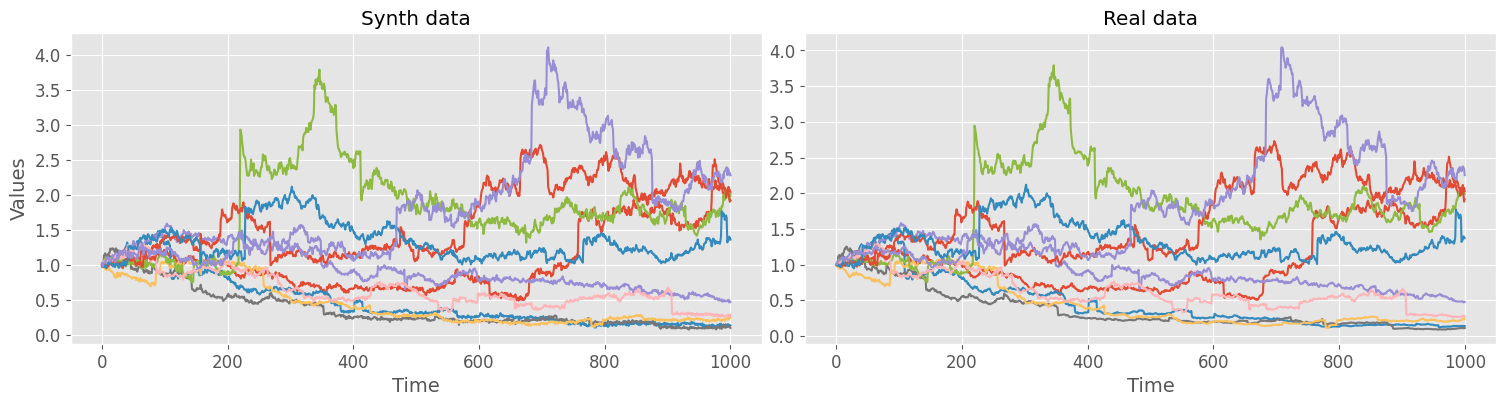

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4), dpi=100)

axs[0].plot(synth_data.T)
axs[0].set_title('Synth data')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Values')

axs[1].plot(real_data.T)
axs[1].set_title('Real data')
axs[1].set_xlabel('Time')

plt.subplots_adjust(wspace=0.1)
plt.tight_layout(pad=0.5)
# plt.savefig('Merton_many_synth2.pdf', dpi=300)
plt.show()

### Fourier Flows

In [28]:
data_tensor_ff = data_tensor[:, :(len(data_tensor[0]) // 4 * 4 + 1 if len(data_tensor[0]) % 4 > 0 else len(data_tensor[0]) - 3)]

In [29]:
fourier_flow = FourierFlow(2**8, len(data_tensor_ff[0]), 10, FFT=True, flip=True, normalize=False)

fourier_flow.fit(data_tensor_ff, epochs=1000)

Loss: -10055.1064453125: 100%|██████████| 1000/1000 [00:32<00:00, 31.21it/s]


In [30]:
rnvp_flow = FourierFlow(2**8, len(data_tensor_ff[0]), 10, FFT=False, flip=True, normalize=False)

rnvp_flow.fit(data_tensor_ff, epochs=1000)

Loss: -3647.078857421875: 100%|██████████| 1000/1000 [00:30<00:00, 32.31it/s]


In [31]:
samples_ff = fourier_flow.sample(M)
samples_rnvp = rnvp_flow.sample(M)

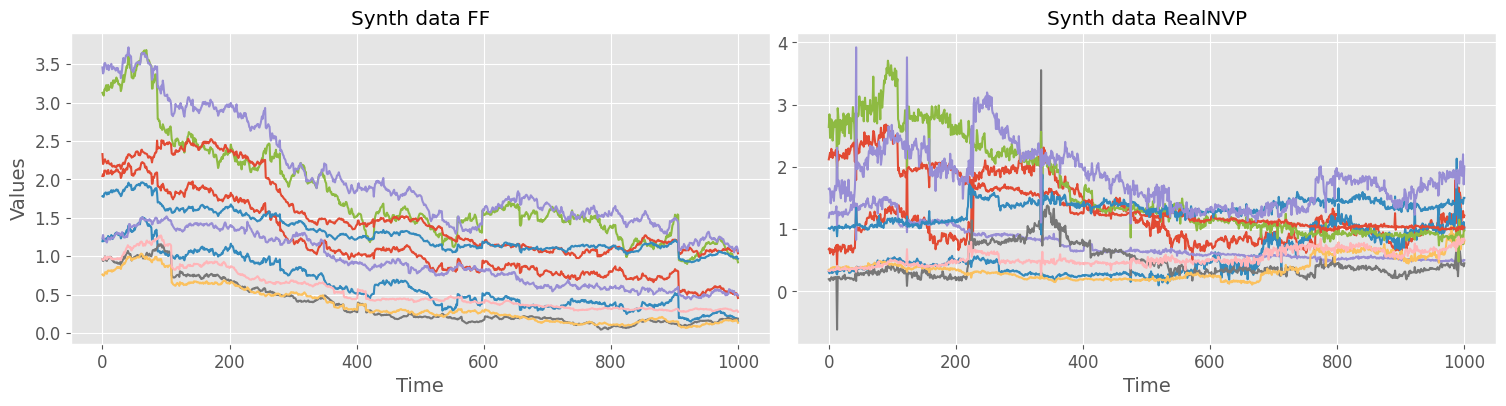

In [32]:
synth_ff = inverse_preprocessing(samples_ff, M, scaler)
synth_rnvp = inverse_preprocessing(samples_rnvp, M, scaler)

fig, axs = plt.subplots(1, 2, figsize=(15, 4), dpi=100)

# axs[0].plot(real_data.T, '--', color='black', alpha=0.7)
axs[0].plot(synth_ff.T)
axs[0].set_title('Synth data FF')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Values')

axs[1].plot(synth_rnvp.T)
axs[1].set_title('Synth data RealNVP')
axs[1].set_xlabel('Time')

plt.subplots_adjust(wspace=0.1)
plt.tight_layout(pad=0.5)
# plt.savefig('Merton_synth_FF.pdf', dpi=300)
plt.show()

### Fractional SDE-Net

Iter: 100, Log Likelihood: 1.7937, Regularization: 134.1222
Iter: 200, Log Likelihood: 1.8052, Regularization: 133.6352
Iter: 300, Log Likelihood: 1.4533, Regularization: 132.9729
Iter: 400, Log Likelihood: 1.9859, Regularization: 132.4384
Iter: 500, Log Likelihood: 2.2677, Regularization: 132.0990
Iter: 100, Log Likelihood: 1.4964, Regularization: 134.2668
Iter: 200, Log Likelihood: 1.8158, Regularization: 133.9596
Iter: 300, Log Likelihood: 2.3467, Regularization: 132.7903
Iter: 400, Log Likelihood: 2.2350, Regularization: 131.8916
Iter: 500, Log Likelihood: 2.3472, Regularization: 130.9120
Iter: 100, Log Likelihood: 1.5612, Regularization: 133.4447
Iter: 200, Log Likelihood: 1.7453, Regularization: 133.0925
Iter: 300, Log Likelihood: 1.9434, Regularization: 132.6257
Iter: 400, Log Likelihood: 1.5072, Regularization: 132.5848
Iter: 500, Log Likelihood: 1.5927, Regularization: 132.0403
Iter: 100, Log Likelihood: 2.3671, Regularization: 134.8291
Iter: 200, Log Likelihood: 2.0776, Regul

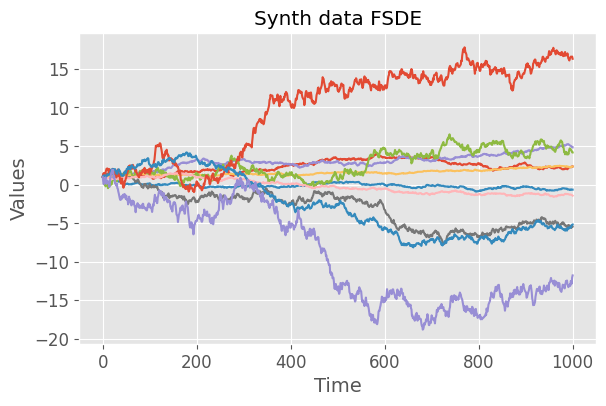

In [33]:
samples_fsde = []
for i in data_tensor:
    samples_fsde.append(train_fsde(i.view(-1, 1), method='RNN', epochs=500))
    
samples_fsde = np.array(samples_fsde)[:, 0]

synth_fsde = inverse_preprocessing(samples_fsde, M, scaler)

plt.subplots(figsize=(6, 4), dpi=100)

plt.plot(synth_fsde.T)
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Synth data FSDE')

plt.tight_layout(pad=0.5)
# plt.savefig('Merton_synth_FSDE.pdf', dpi=300)
plt.show()

In [34]:
synth_data[[1, 2, 3]]

array([[1.0059743 , 1.02035   , 1.0387418 , ..., 0.13872689, 0.13941748,
        0.13432904],
       [1.0135422 , 1.0360289 , 1.023824  , ..., 0.46248966, 0.4812775 ,
        0.46998972],
       [1.0040864 , 1.0175713 , 1.0051534 , ..., 0.1189193 , 0.11412878,
        0.09835546]], dtype=float32)

In [102]:
samples_fsde = np.append(samples_fsde, samples[[0, 1, -2, -1]], axis=0)

In [159]:
synth_fsde = np.append(synth_fsde, synth_data[[0, 1]], axis=0)

In [112]:
synth_fsde = np.delete(synth_fsde, [4, 5], axis=0)

In [111]:
samples_fsde = np.delete(samples_fsde, [4, 5], axis=0)

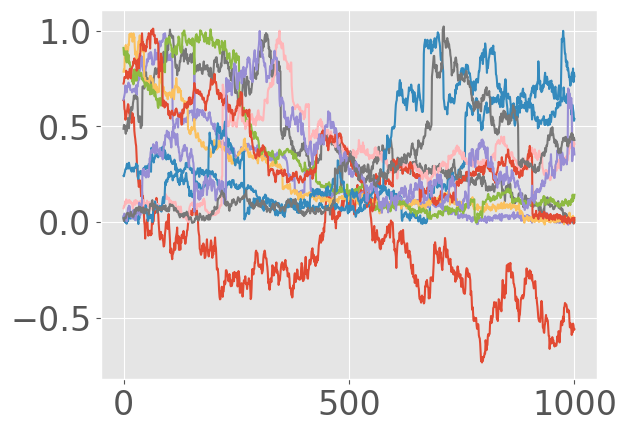

In [158]:
plt.plot(samples_fsde[1])
plt.plot(samples.T)
plt.show()

In [313]:
synth_fsde = np.append(synth_fsde, synth_data[[1, 2, 3, 0, 5]], axis=0)

In [314]:
samples_fsde = np.append(samples_fsde, samples[[1, 2, 3, 0, 5]], axis=0)

In [345]:
samples_fsde = np.delete(samples_fsde, [4,5], axis=0)

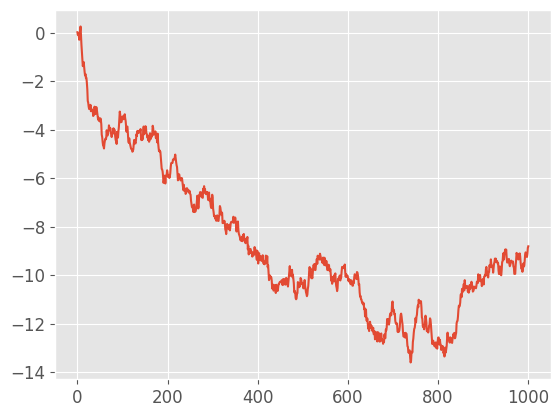

In [344]:
plt.plot(samples_fsde[4])

### TimeGAN

In [39]:
# from JDFLOW.timeGAN import timeGAN_train

# samples_timeGAN, pca_timeGAN = timeGAN_train(data, M, 2000)
# samples_timeGAN = samples_timeGAN.T

In [40]:
# synth_timeGAN = inverse_preprocessing(samples_timeGAN, M, scaler)

In [41]:
# plt.plot(data.T, color='black', alpha=0.7)
# plt.plot(synth_timeGAN.T, alpha=0.7)
# plt.show()

### PAR from SDV

In [35]:
from sdv.sequential import PARSynthesizer
from sdv.metadata import SingleTableMetadata

df_ctgan = pd.DataFrame(data.T, columns=[f'{i}' for i in range(M)])
df_ctgan['date'] = pd.to_datetime(pd.date_range(start='2018-01-01', periods=len(data[0])), format='%Y-%m-%d')
df_ctgan['id'] = ['AAA']*len(data[0])

metadata = SingleTableMetadata()

for i in range(M):
    metadata.add_column(
        column_name=f'{i}',
        sdtype='numerical')
    
metadata.add_column(
    column_name='date',
    sdtype='datetime',
    datetime_format='%Y-%m-%d')

metadata.add_column(
    column_name='id',
    sdtype='id')

metadata.set_sequence_index(column_name='date')
metadata.set_sequence_key(column_name='id')

In [80]:
par = PARSynthesizer(metadata=metadata, epochs=500, verbose=True, enforce_min_max_values=True)
par.fit(df_ctgan)

samples_PAR = par.sample(num_sequences=1)
samples_PAR = samples_PAR.iloc[:, :M].values.T

Epoch 500 | Loss -966.643798828125: 100%|██████████| 500/500 [01:18<00:00,  6.33it/s]  
100%|██████████| 1/1 [00:07<00:00,  7.88s/it]


In [81]:
synth_PAR = inverse_preprocessing(samples_PAR, M, scaler)

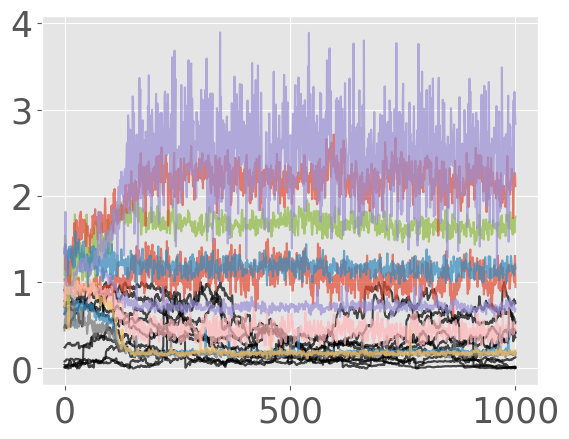

In [82]:
plt.plot(data.T, color='black', alpha=0.7)
plt.plot(synth_PAR.T, alpha=0.7)
plt.show()

## Evaluate

In [143]:
mpl.rcParams['xtick.labelsize'] = 24
mpl.rcParams['ytick.labelsize'] = 24
mpl.rcParams['legend.fontsize'] = 23
mpl.rcParams['axes.labelsize'] = 27

### Signtature distribution

In [118]:
def signature_set_all(signature_traj, dim) -> list:
    signature_all = []
    for k in range(0, dim, 5): 
        signature_f = []
        for i in signature_traj:
            for j in i:
                signature_f.append(j[k])
        
        signature_all.append(signature_f[1:])
        
    return signature_all

In [119]:
signature_traj = compute_path_signature_torch(data_tensor, level_threshold=3)
signature_real = signature_set_all(signature_traj, data_tensor.size(1) - 1)

signature_traj = compute_path_signature_torch(torch.FloatTensor(samples), level_threshold=3)
signature = signature_set_all(signature_traj, torch.FloatTensor(samples).size(1) - 1)

signature_traj = compute_path_signature_torch(torch.FloatTensor(samples_ff), level_threshold=3)
signature_ff = signature_set_all(signature_traj, torch.FloatTensor(samples_ff).size(1) - 1)

signature_traj = compute_path_signature_torch(torch.FloatTensor(samples_PAR), level_threshold=3)
signature_PAR = signature_set_all(signature_traj, torch.FloatTensor(samples_PAR).size(1) - 1)

signature_traj = compute_path_signature_torch(torch.FloatTensor(samples_fsde), level_threshold=3)
signature_fsde = signature_set_all(signature_traj, torch.FloatTensor(samples_fsde).size(1) - 1)

In [120]:
w1_dist_sig_jdflow = []
w1_dist_sig_ff = []
w1_dist_sig_par = []
w1_dist_sig_fsde = []

for i in range(len(signature_real)):
    w1_dist_sig_jdflow.append(wasserstein_distance(signature_real[i], signature[i]))
    w1_dist_sig_ff.append(wasserstein_distance(signature_real[i], signature_ff[i]))
    w1_dist_sig_par.append(wasserstein_distance(signature_real[i], signature_PAR[i]))
    w1_dist_sig_fsde.append(wasserstein_distance(signature_real[i], signature_fsde[i]))

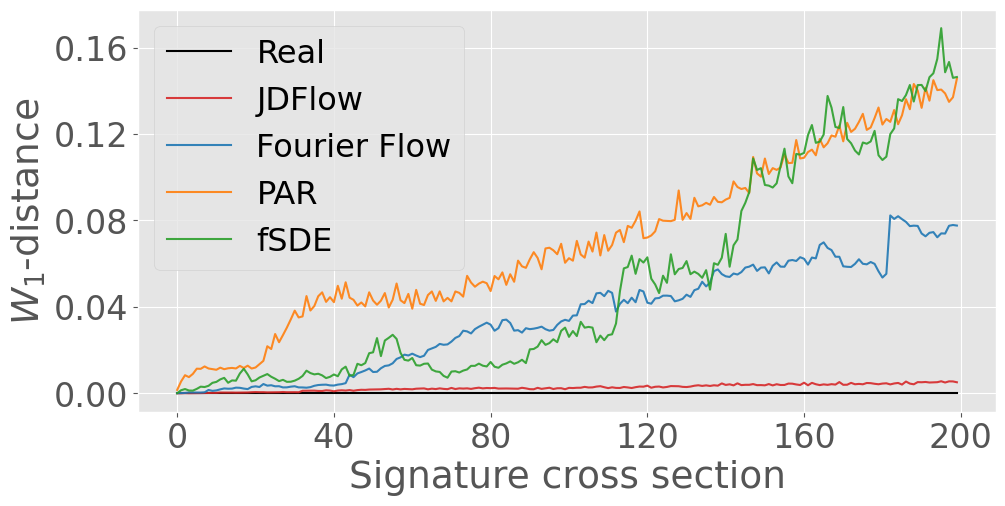

In [145]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(np.arange(len(w1_dist_sig_jdflow)), [0]*len(w1_dist_sig_jdflow), color='black', label='Real')
plt.plot(w1_dist_sig_jdflow, label='JDFlow', color='tab:red', alpha=0.9)
plt.plot(w1_dist_sig_ff, label='Fourier Flow', color='tab:blue', alpha=0.9)
plt.plot(w1_dist_sig_par, label='PAR', color='tab:orange', alpha=0.9)
plt.plot(w1_dist_sig_fsde, label='fSDE', color='tab:green', alpha=0.9)

plt.xlabel('Signature cross section')
plt.ylabel('$W_1$-distance')
plt.xticks(np.arange(0, 201, 40))
plt.yticks(np.arange(0, 0.2, 0.04))
plt.legend()
plt.tight_layout(pad=0.5)
plt.savefig(f'Sig_Cross_Merton.pdf', dpi=300) #save figure
plt.show()

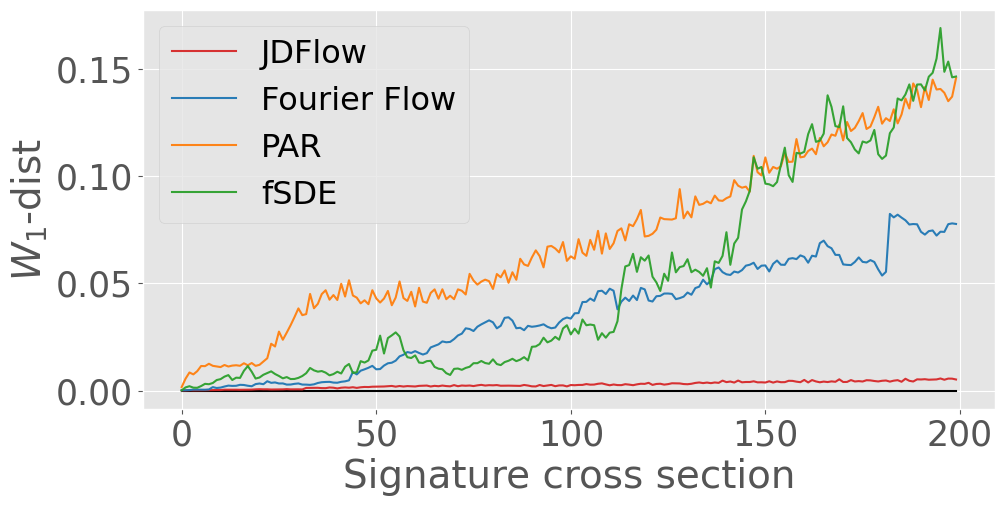

In [114]:
plot_signature_w1_dist(data_tensor, samples, samples_ff, samples_PAR, samples_fsde, save=False, name='Sig_cross_Merton')

In [42]:
# fig, axs = plt.subplots(2, 2, figsize=(10, 5), dpi=100)

# signature_traj = compute_path_signature_torch(torch.FloatTensor(samples), level_threshold=3)
# signature = signature_set(signature_traj)[1:]

# signature_traj = compute_path_signature_torch(data_tensor, level_threshold=3)
# signature_real = signature_set(signature_traj)[1:]

# signature_traj = compute_path_signature_torch(torch.FloatTensor(samples_ff), level_threshold=3)
# signature_ff = signature_set(signature_traj)[1:]

# signature_traj = compute_path_signature_torch(torch.FloatTensor(samples_PAR), level_threshold=3)
# signature_PAR = signature_set(signature_traj)[1:]

# signature_traj = compute_path_signature_torch(torch.FloatTensor(samples_fsde), level_threshold=3)
# signature_fsde = signature_set(signature_traj)[1:]



# axs[0, 0].hist(signature_real, bins=np.arange(-2, 2, 0.1), label='Real', color='black', alpha=0.7, density=True)
# axs[0, 0].hist(signature, bins=np.arange(-2, 2, 0.1), label='JDFlow', color='tab:red', alpha=0.7, density=True)
# axs[0, 0].set_xlabel('Values')
# axs[0, 0].set_ylabel('Frequencies')
# axs[0, 0].legend()


# axs[0, 1].hist(signature_real, bins=np.arange(-2, 2, 0.1), label='Real', color='black', alpha=0.7, density=True)
# axs[0, 1].hist(signature_ff, bins=np.arange(-2, 2, 0.1), label='Fourier Flow', color='tab:blue', alpha=0.7, density=True)
# axs[0, 1].set_xlabel('Values')
# # axs[0, 1].set_ylabel('Frequencies')
# axs[0, 1].legend()


# axs[1, 0].hist(signature_real, bins=np.arange(-2, 2, 0.1), label='Real', color='black', alpha=0.7, density=True)
# axs[1, 0].hist(signature_PAR, bins=np.arange(-2, 2, 0.1), label='PAR', color='tab:orange', alpha=0.7, density=True)
# axs[1, 0].set_xlabel('Values')
# axs[1, 0].set_ylabel('Frequencies')
# axs[1, 0].legend()


# axs[1, 1].hist(signature_real, bins=np.arange(-2, 2, 0.1), label='Real', color='black', alpha=0.7, density=True)
# axs[1, 1].hist(signature_fsde, bins=np.arange(-2, 2, 0.1), label='fSDE', color='tab:green', alpha=0.7, density=True)
# axs[1, 1].set_xlabel('Values')
# # axs[0, 0].set_ylabel('Frequencies')
# axs[1, 1].legend()

# plt.subplots_adjust(wspace=0.3)
# plt.tight_layout(pad=0.5)
# # plt.savefig(f'Signature_Stock.pdf', dpi=300) #save figure
# plt.show()

In [47]:
# plot_signature(data_tensor, samples, samples_ff, samples_PAR, samples_fsde, save=False, name='Signature_test')

### Local extrema QQ-plot

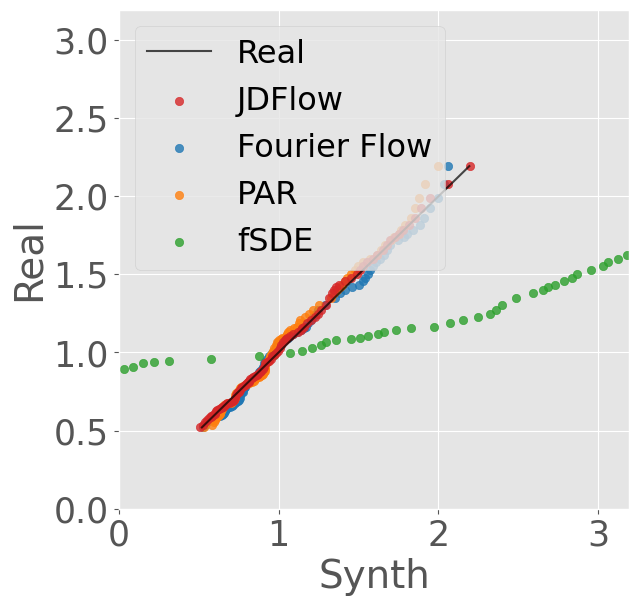

In [63]:
plot_qq_extrema_all(real_data, synth_data, synth_ff, synth_PAR, synth_fsde, save=False, name='QQExtrema')

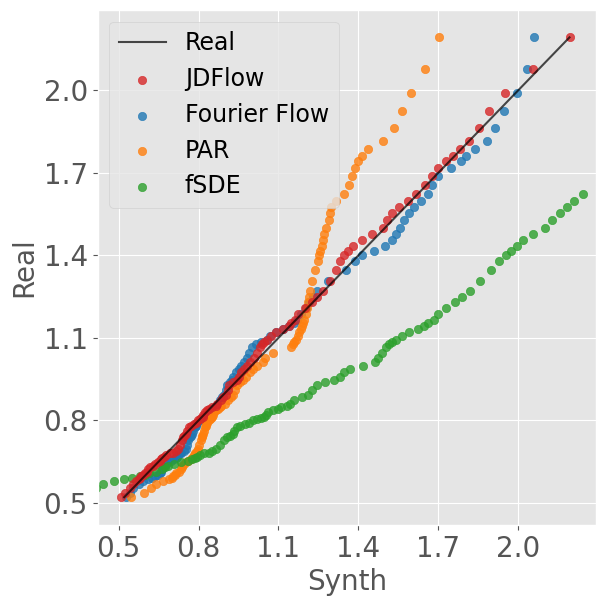

In [137]:
fig = plt.subplots(figsize=(6, 6), dpi=100)

real_qqextr = extr_quant_computation(real_data)

plt.plot(real_qqextr, real_qqextr, color='black', label='Real', zorder=4, alpha=0.7)
plt.scatter(extr_quant_computation(synth_data), extr_quant_computation(real_data), color='tab:red', label='JDFlow', zorder=3, alpha=0.8)
plt.scatter(extr_quant_computation(synth_ff), extr_quant_computation(real_data), color='tab:blue', label='Fourier Flow', alpha=0.8)
plt.scatter(extr_quant_computation(synth_PAR), extr_quant_computation(real_data), color='tab:orange', label='PAR', alpha=0.8)
plt.scatter(extr_quant_computation(synth_fsde), extr_quant_computation(real_data), color='tab:green', label='fSDE', alpha=0.8)

plt.xlabel('Synth', fontsize=20)
plt.ylabel('Real', fontsize=20)
plt.xticks(np.arange(0.5, 2.5, 0.3), fontsize=20)
plt.yticks(np.arange(0.5, 2.5, 0.3), fontsize=20)
plt.xlim((real_qqextr.min()-0.1, real_qqextr.max()+0.1))
plt.ylim((real_qqextr.min()-0.1, real_qqextr.max()+0.1))

plt.legend(fontsize=17)
plt.tight_layout(pad=0.5)

# plt.savefig(f'QQExtrema_Merton.pdf', dpi=300) #save figure
plt.show()

### Autocorrelation

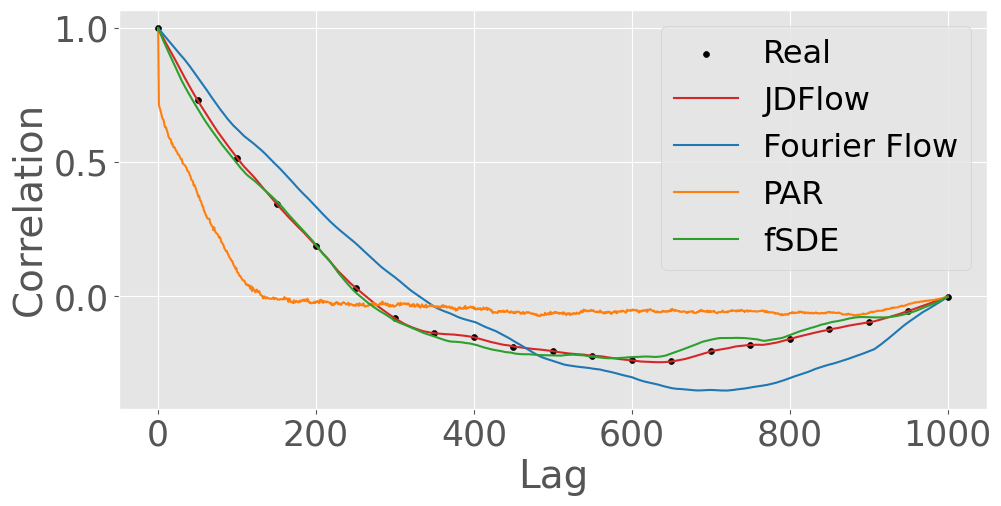

In [140]:
plot_autocorr_all(real_data, synth_data, synth_ff, synth_PAR, synth_fsde, save=False, name='Autocorrelation')

In [148]:
# fig = plt.subplots(figsize=(10, 5), dpi=100)

# # real_qqextr = extr_quant_computation(real_data)

# plt.scatter(np.arange(0, len(real_data[0]))[::50], autocorr_vec(real_data)[::50], marker='o', label = 'Real', color='black', s=18)
# plt.plot(autocorr_vec(synth_data), label = 'JDFlow', color='tab:red')
# plt.plot(autocorr_vec(synth_ff), label = 'Fourier Flow', color='tab:blue')
# plt.plot(autocorr_vec(synth_PAR), label = 'PAR', color='tab:orange')
# plt.plot(autocorr_vec(synth_fsde), label = 'fSDE', color='tab:green')

# plt.xlabel('Lag')
# plt.ylabel('Correlation')
# plt.xticks()
# plt.yticks(np.arange(-0.4, 1.10, 0.2))

# plt.legend()
# plt.tight_layout(pad=0.5)

# # plt.savefig(f'Autocorr_Merton.pdf', dpi=300) #save figure
# plt.show()

In [150]:
# plot_autocorr(real_data, synth_data, synth_ff, synth_PAR, synth_fsde, save=False, name='Autocorr_test')

### Numerical evaluation

In [166]:
pd.DataFrame(np.array([[w_dist_calc(real_data, real_data), w_dist_calc(real_data, synth_data),
                        w_dist_calc(real_data, synth_ff), w_dist_calc(real_data, synth_PAR), w_dist_calc(real_data, synth_fsde)],
                       
                       [js_calc(np.abs(real_data), np.abs(real_data)), js_calc(np.abs(real_data), np.abs(synth_data)),
                        js_calc(np.abs(real_data), np.abs(synth_ff)), js_calc(np.abs(real_data), np.abs(synth_PAR)), js_calc(np.abs(real_data), np.abs(synth_fsde))]
                       
                       ]).T, index=['Real', 'JDFLOW', 'FF', 'PAR', 'fSDE'], columns=['W_1', 'JS'])

,W_1,JS
Real,0.000000,0.000000
JDFLOW,0.003809,0.006733
FF,0.105682,0.135125
PAR,0.272122,0.140065
fSDE,0.923104,0.257309


### TSNE

In [46]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import FastICA

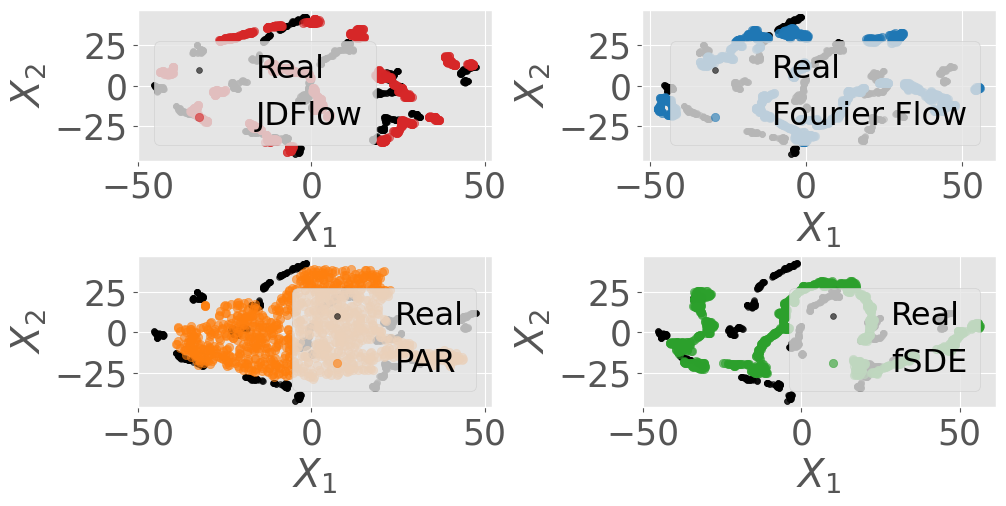

In [47]:
plot_tsne(real_data, synth_data, synth_ff, synth_PAR, synth_fsde, save=False, name='TSNE_Stock')

In [123]:
# pca = PCA(n_components=2)
# pca_real = pca.fit_transform(real_data.T)
# pca_jdflow = pca.transform(synth_data.T)
# pca_PAR = pca.transform(synth_PAR.T)
# pca_FF = pca.transform(synth_ff.T)
# pca_rnvp = pca.transform(synth_rnvp.T)
# pca_fsde = pca.transform(synth_fsde.T)

In [217]:
pca = TSNE(n_components=2)
pca_real = pca.fit_transform(real_data.T)
pca_jdflow = pca.fit_transform(synth_data.T)
pca_PAR = pca.fit_transform(synth_PAR.T)
pca_FF = pca.fit_transform(synth_ff.T)
pca_rnvp = pca.fit_transform(synth_rnvp.T)
pca_fsde = pca.fit_transform(synth_fsde.T)

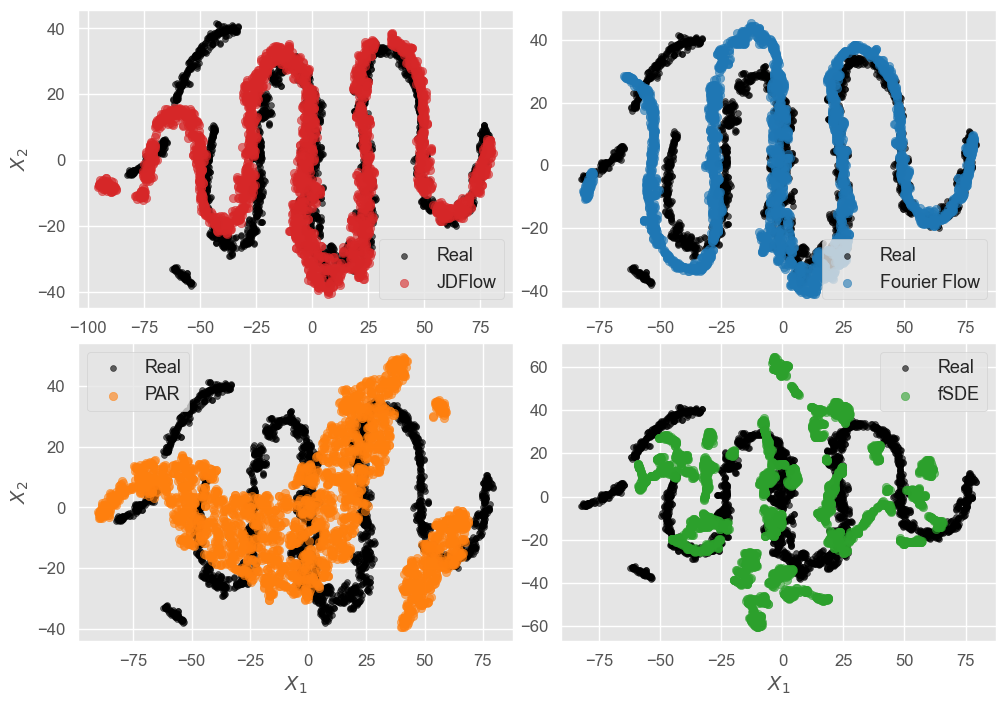

In [221]:
fig, axs = plt.subplots(2, 2, figsize=(10, 7), dpi=100)

axs[0, 0].scatter(pca_real[:, 0], pca_real[:, 1], marker='o', label = 'Real', color='black', s=18, alpha=0.6)
axs[0, 0].scatter(pca_jdflow[:, 0], pca_jdflow[:, 1], label = 'JDFlow', color='tab:red', alpha=0.6)
# axs[0, 0].set_xlabel('$X_1$')
axs[0, 0].set_ylabel('$X_2$')
axs[0, 0].legend()


axs[0, 1].scatter(pca_real[:, 0], pca_real[:, 1], marker='o', label = 'Real', color='black', s=18, alpha=0.6)
axs[0, 1].scatter(pca_FF[:, 0], pca_FF[:, 1], label = 'Fourier Flow', color='tab:blue', alpha=0.6)
# axs[0, 1].set_xlabel('$X_1$')
# axs[0, 1].set_ylabel('$X_2$')
axs[0, 1].legend()

axs[1, 0].scatter(pca_real[:, 0], pca_real[:, 1], marker='o', label = 'Real', color='black', s=18, alpha=0.6)
axs[1, 0].scatter(pca_PAR[:, 0], pca_PAR[:, 1], label = 'PAR', color='tab:orange', alpha=0.6)
axs[1, 0].set_xlabel('$X_1$')
axs[1, 0].set_ylabel('$X_2$')
axs[1, 0].legend()

axs[1, 1].scatter(pca_real[:, 0], pca_real[:, 1], marker='o', label = 'Real', color='black', s=18, alpha=0.6)
axs[1, 1].scatter(pca_fsde[:, 0], pca_fsde[:, 1], label = 'fSDE', color='tab:green', alpha=0.6)
axs[1, 1].set_xlabel('$X_1$')
# axs[1, 1].set_ylabel('$X_2$')
axs[1, 1].legend()


plt.xticks()
plt.yticks()
plt.tight_layout(pad=0.5)
# plt.savefig(f'TSNE_Stock.pdf', dpi=300) #save figure
plt.show()

In [152]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error

In [153]:
# n = 31
# test_size = len(real_data[0])//n - 1
# train_size_init = int(len(real_data[0]) - n*test_size)

# def forecasting_cv(synth, real, train_size_init, test_size, n):
#     array_mse = []
#     train = synth[:, :train_size_init]
    

    
#     for j in range(len(real)):
#         train_iter = copy.deepcopy(train[j])
#         mse_iter = []
#         train_size = train_size_init
        
#         for _ in range(n-2):
#             df = pd.DataFrame()
#             df['y'] = train_iter
#             df.index = pd.date_range(start='1/1/2022', periods=len(train_iter), freq='D')
#             df = df.reset_index()
#             df = df.rename(columns={'index': 'ds'})

#             m = Prophet(daily_seasonality=True)
#             m.fit(df)
            
#             future = m.make_future_dataframe(periods = test_size)
#             pred_synth = m.predict(future)['yhat'][-test_size:]
                        
#             test_synth = synth[j, train_size : (train_size+test_size)]
#             test_real = real[j, train_size : (train_size+test_size)]
            
#             mse = mean_squared_error(pred_synth.values, test_real)
            
#             train_iter = np.concatenate([train_iter, test_synth])
            
#             train_size += test_size
     
            
#             mse_iter.append(mse)
       
        
#         array_mse.append(np.mean(mse_iter))
        
#     return array_mse

In [164]:
# mse_real = np.array(forecasting_cv(real_data, real_data, train_size_init, test_size, n))
# mse_jdflow = np.array(forecasting_cv(synth_data, real_data, train_size_init, test_size, n))
# mse_ff = np.array(forecasting_cv(synth_ff, real_data, train_size_init, test_size, n))
# mse_par = np.array(forecasting_cv(synth_PAR, real_data, train_size_init, test_size, n))
# mse_fsde = np.array(forecasting_cv(synth_fsde, real_data, train_size_init, test_size, n))

In [165]:
# pd.DataFrame([[mse_real.mean(), np.min(mse_real), np.max(mse_real)],
#               [mse_jdflow.mean(), np.min(mse_jdflow), np.max(mse_jdflow)],
#               [mse_ff.mean(), np.min(mse_ff), np.max(mse_ff)],
#               [mse_par.mean(), np.min(mse_par), np.max(mse_par)],
#               [mse_fsde.mean(), np.min(mse_fsde), np.max(mse_fsde)]],\
#              columns=['Mean', 'Min', 'Max'], index = ['Real', 'JDFlow', 'Fourier Flow', 'PAR', 'fSDE'])

In [49]:
forecast_metrics(real_data, synth_data, synth_PAR, synth_fsde, n=31)

NameError: name 'copy' is not defined

In [139]:
extr_min = argrelextrema(real_data[0], np.less_equal, order=10)[0]
local_extr_min_real = real_data[0][extr_min]

extr_min_par = argrelextrema(synth_PAR[0], np.less_equal, order=10)[0]
local_extr_min_par = synth_PAR[0][extr_min_par]

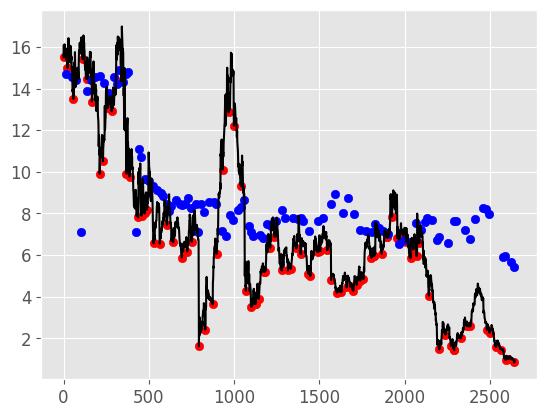

In [141]:
plt.plot(real_data[0], color='black')
plt.scatter(extr_min, local_extr_min_real, color='red')
plt.scatter(extr_min_par, local_extr_min_par, color='blue')
plt.show()